# How to benefit from high-resolution digital elevation models to simulate partial beam blockage?

$K.Muehlbauer^{1}$ (kai.muehlbauer@uni-bonn.de),  $M.Heistermann^{2}$

- $^{1}$ University of Bonn, Germany
- $^{2}$ University of Potsdam, Germany

## Short Abstract

In complex terrain, partial beam blockage (PBB) is among the prime sources of uncertainty in radar-based quantitative precipitation estimation. While polarimetry offers strategies to mitigate the issue (as e.g. KDP is considered rather immune to PBB), the quantification of PBB remains important (e.g. for single-pol data processing, or for exploring suitable locations to set up new radar devices).

A common procedure to quantify partial beam blockage is to simulate beam propagation through the atmosphere, and to quantify interference with the terrain surface as represented by a digital elevation model. A couple of authors (e.g. Bech et al. 2007) have suggested to interpolate (or resample) the terrain altitude to each radar range bin location. As a consequence, beam blockage would be computed based on some “average” terrain altitude in the radar bin. This may produce errors in areas with rapid terrain variations. As long as the spatial resolution of the DEM is low (e.g. 1 km in GTOPO30), the additional error introduced by interpolation and averaging might be negligible. However, modern DEMs provide resolutions of up to 1 meter - just resampling terrain altitude to the radar bin location is an unnecessary loss of information. Instead, we should consider all terrain values inside any radar bin.

In this study, we present a new algorithm based on the open source software wradlib, that reprojects high-resolution terrain altitude directly into the spherical coordinate reference system of the weather radar. That way, we explicitly represent the terrain cross section as seen by the radar, or, in other words, the variation of topography “inside” each radar bin. We then convolve, for each radar bin, the high-resolution terrain cross-section with a Gaussian power distribution of the radar beam in order to simulate the bam blockage fraction. We will systematically evaluate the effects of our technique on cumulative beam blockage along the beam propagation path, in comparison to the simple resampling approach: for different DEM resolutions, radar set-ups and terrain surfaces. Preliminary analysis suggests that the resulting changes in simulated beam blockage can be dramatic (> 50 %).

## Overview

* A typical approach

* A new approach

* Preliminary Results

| [Bech et.al. (2003)](https://journals.ametsoc.org/doi/abs/10.1175/1520-0426%282003%29020%3C0845%3ATSOSPW%3E2.0.CO%3B2) | [Cremonini et.al. (2016)](https://doi.org/10.5194/amt-9-5063-2016) |
|:---:|:---:|
| ![alt](assets/bech.png) | ![alt](assets/cremonini.png) |
| * Interpolate DEM to obtain only one representative terrain altitude per bin  | * Consider terrain profile over beam cross section by digitizing over point cloud |
| * Consideration of energy distribution via half-power beam radius | * Consideration of energy distribution via Gaussian antenna pattern |

## Current State of Art

* Typical Procedure

    * Kucera et.al. 2004:
        Estimate bin center height and compare with DEM height, spline interpolation in azimuth
    * Bech et.al. 2003+2007:
        Interpolate/Resample DEM altitude to radar bin altitude (implemented in wradlib) and compare with DEM height

* Using High resolution DEM

    * Cremonini et.al 2016:
        Extract DEM-profile per radar bin and take energy distribution into consideration

## Comparison of source data sets

In [1]:
import wradlib as wrl
import matplotlib.pyplot as pl
import matplotlib as mpl
import warnings
warnings.filterwarnings('ignore')
try:
    get_ipython().magic("matplotlib inline")
except:
    pl.ion()
import numpy as np

/home/kai/miniconda3/envs/wradlib/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
sitecoords = (7.071663, 50.73052, 99.5)
nrays = 360 # number of rays
nbins = 1000 # number of range bins
el = 2.0 # vertical antenna pointing angle (deg)
bw = 1.0 # half power beam width (deg)
range_res = 100. # range resolution (meters)
r = np.arange(nbins) * range_res
beamradius = wrl.util.half_power_radius(r, bw)

In [3]:
utm_proj = wrl.georef.epsg_to_osr(25832)
wgs84_proj = wrl.georef.epsg_to_osr(4326)

utm_site = wrl.georef.reproject(sitecoords, projection_source=wgs84_proj, 
                                projection_target=utm_proj)
print(utm_site)
print(utm_proj)

[3.63912156e+05 5.62163162e+06 9.95000000e+01]
PROJCS["ETRS89 / UTM zone 32N",
    GEOGCS["ETRS89",
        DATUM["European_Terrestrial_Reference_System_1989",
            SPHEROID["GRS 1980",6378137,298.257222101,
                AUTHORITY["EPSG","7019"]],
            TOWGS84[0,0,0,0,0,0,0],
            AUTHORITY["EPSG","6258"]],
        PRIMEM["Greenwich",0,
            AUTHORITY["EPSG","8901"]],
        UNIT["degree",0.0174532925199433,
            AUTHORITY["EPSG","9122"]],
        AUTHORITY["EPSG","4258"]],
    PROJECTION["Transverse_Mercator"],
    PARAMETER["latitude_of_origin",0],
    PARAMETER["central_meridian",9],
    PARAMETER["scale_factor",0.9996],
    PARAMETER["false_easting",500000],
    PARAMETER["false_northing",0],
    UNIT["metre",1,
        AUTHORITY["EPSG","9001"]],
    AXIS["Easting",EAST],
    AXIS["Northing",NORTH],
    AUTHORITY["EPSG","25832"]]


### create radar grids

Radar `gr_xyz`-grid depending on refraction (elevation) and earth's curvature using wradlib `georef.spherical_to_xyz`.

In [4]:
# create gr range and azimuth arrays
polargrid = wrl.georef.sweep_centroids(nrays, range_res, nbins, el)
print(polargrid.shape)

# create gr polar grid and calculate aeqd-xyz coordinates
gr_xyz, rad = wrl.georef.spherical_to_xyz(polargrid[..., 0], 
                                          polargrid[..., 1], 
                                          polargrid[..., 2], sitecoords)
print("XYZ-Grid-Shape:", gr_xyz.shape)
print(rad)

(360, 1000, 3)
XYZ-Grid-Shape: (360, 1000, 3)
PROJCS["unnamed",
    GEOGCS["WGS 84",
        DATUM["WGS_1984",
            SPHEROID["WGS 84",6378137,298.257223563,
                AUTHORITY["EPSG","7030"]],
            AUTHORITY["EPSG","6326"]],
        PRIMEM["Greenwich",0,
            AUTHORITY["EPSG","8901"]],
        UNIT["degree",0.0174532925199433,
            AUTHORITY["EPSG","9122"]],
        AUTHORITY["EPSG","4326"]],
    PROJECTION["Azimuthal_Equidistant"],
    PARAMETER["latitude_of_center",50.73052],
    PARAMETER["longitude_of_center",7.071663],
    PARAMETER["false_easting",0],
    PARAMETER["false_northing",0],
    UNIT["Meter",1]]


In [5]:
# reproject aeqd to utm
utm_xyz = wrl.georef.reproject(gr_xyz, projection_source=rad, 
                               projection_target=utm_proj)
print(utm_xyz.shape)

(360, 1000, 3)


In [7]:
%%time
demfile = 'data/bonn_dgm2_lzma.tif'
ds = wrl.io.open_raster(demfile)
dem_coords = wrl.georef.read_gdal_coordinates(ds)
dem_values = wrl.georef.read_gdal_values(ds)
dem_proj = wrl.georef.read_gdal_projection(ds)
print(dem_coords.shape)
print(dem_proj)

(10000, 10000, 3)
PROJCS["ETRS89 / UTM zone 32N",
    GEOGCS["ETRS89",
        DATUM["European_Terrestrial_Reference_System_1989",
            SPHEROID["GRS 1980",6378137,298.257222101,
                AUTHORITY["EPSG","7019"]],
            TOWGS84[0,0,0,0,0,0,0],
            AUTHORITY["EPSG","6258"]],
        PRIMEM["Greenwich",0,
            AUTHORITY["EPSG","8901"]],
        UNIT["degree",0.0174532925199433,
            AUTHORITY["EPSG","9122"]],
        AUTHORITY["EPSG","4258"]],
    PROJECTION["Transverse_Mercator"],
    PARAMETER["latitude_of_origin",0],
    PARAMETER["central_meridian",9],
    PARAMETER["scale_factor",0.9996],
    PARAMETER["false_easting",500000],
    PARAMETER["false_northing",0],
    UNIT["metre",1,
        AUTHORITY["EPSG","9001"]],
    AXIS["Easting",EAST],
    AXIS["Northing",NORTH],
    AUTHORITY["EPSG","25832"]]
CPU times: user 2.33 s, sys: 1.27 s, total: 3.6 s
Wall time: 4.05 s


## reproject DEM to AEQD

for visualisation purposes

In [8]:
%%time
dem_xyz = wrl.georef.reproject(dem_coords, projection_source=dem_proj,
                               projection_target=rad)

CPU times: user 3min 25s, sys: 4.44 s, total: 3min 29s
Wall time: 3min 29s


In [15]:
# add terrain hights
dem_xyz[..., 2] = dem_values
print(wrl.util.get_raster_origin(dem_xyz[...,0:2]))

upper


## interpolate DEM to polar grid

* project polargrid to aeqd
* interpolate DEM using `scipy.ndimage.map_coordinates`

In [16]:
coords = wrl.georef.spherical_to_proj(polargrid[..., 0], 
                                      np.degrees(polargrid[..., 1]),
                                      polargrid[..., 2], sitecoords,
                                      proj=rad,
                                     )
polcoords = coords[..., :2]
lon = coords[..., 0]
lat = coords[..., 1]
alt = coords[..., 2]
rlimits = (lon.min(), lat.min(), lon.max(), lat.max())
print("Radar bounding box:\n\t%.2f\n%.2f             %.2f\n\t%.2f" % 
      (lat.max(), lon.min(), lon.max(), lat.min()))
print(polcoords.shape)
print(coords.shape)

Radar bounding box:
	99838.50
-99838.50             99838.50
	-99838.50
(360, 1000, 2)
(360, 1000, 3)


In [17]:
%%time
# Map rastervalues to polar grid points
polarvalues = wrl.ipol.cart_to_irregular_spline(dem_xyz[..., 0:2], 
                                                dem_xyz[..., 2],
                                                polcoords, 
                                                order=3,
                                                prefilter=False)

CPU times: user 656 ms, sys: 0 ns, total: 656 ms
Wall time: 654 ms


In [145]:
from matplotlib.colors import LogNorm
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_cartesian(data, skip, ax):
    dem = ax.pcolormesh(data[::skip, ::skip, 0]/1000., data[::skip, ::skip, 1]/1000.,
                   data[::skip, ::skip, 2], 
                   #norm=LogNorm(), 
                   cmap=pl.cm.terrain,
                   vmin=50, vmax=160,
                  )
    div1 = make_axes_locatable(ax)
    cax1 = div1.append_axes("right", size="5%", pad=0.1)
    cb = pl.gcf().colorbar(dem, cax=cax1)#,
                               #ticks=ticker.LogLocator(subs=range(10)))
    cb.set_label('terrain height [m]', size=24)
    ax.set_title("High Resolution DEM 1m Resolution")
    ax.plot(0, 0, '*r')
    ax.set_xlim(-2, 2)
    ax.set_ylim(-2, 2)
    ax.set_xlabel('XRange [km]')
    ax.set_ylabel('YRange [km]')
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(24)
    cb.ax.tick_params(labelsize=24)


def plot_polar(coords, data, ax):
    polcoords = np.append(coords, coords[0]).reshape(coords.shape[0]+1, 
                                                     coords.shape[1], 2)
    dem = ax.pcolormesh(polcoords[:, 0:100, 0], polcoords[:, 0:100, 1],
                       data[:, 0:100], 
                       #norm=LogNorm(), 
                       cmap=pl.cm.terrain,
                       vmin=50, vmax=160,
                      )
    div1 = make_axes_locatable(ax)
    cax1 = div1.append_axes("right", size="5%", pad=0.1)
    cb = pl.gcf().colorbar(dem, cax=cax1)#,
                               #ticks=ticker.LogLocator(subs=range(10)))
    cb.set_label('terrain height [m]', size=24)
    ax.set_title("DEM Interpolated to Polar Radar Grid")
    ax.plot(0, 0, '*r')
    ax.set_xlim(-2000, 2000)
    ax.set_ylim(-2000, 2000)
    ax.set_xlabel('XRange [km]')
    ax.set_ylabel('YRange [km]')
    pl.gcf().canvas.draw()
    xlabels = [item.get_position()[0]/1000. for item in ax.get_xticklabels()]
    ylabels = [item.get_position()[1]/1000. for item in ax.get_yticklabels()]
    ax.set_xticklabels(xlabels)
    ax.set_yticklabels(ylabels)
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(24)
    cb.ax.tick_params(labelsize=24)

In [146]:
def plot_1():
    sp = 5
    fig = pl.figure(figsize=(10,10))
    ax = fig.add_subplot(111, aspect='equal')
    plot_cartesian(dem_xyz, sp, ax)
    pl.tight_layout()
    pl.savefig("assets/image_001.png")
    
    
    #pl.show()
def plot_2():
    fig = pl.figure(figsize=(10,10))
    ax = fig.add_subplot(111, aspect='equal')
    plot_polar(polcoords, polarvalues, ax)
    pl.tight_layout()
    pl.savefig("assets/image_002.png")
    

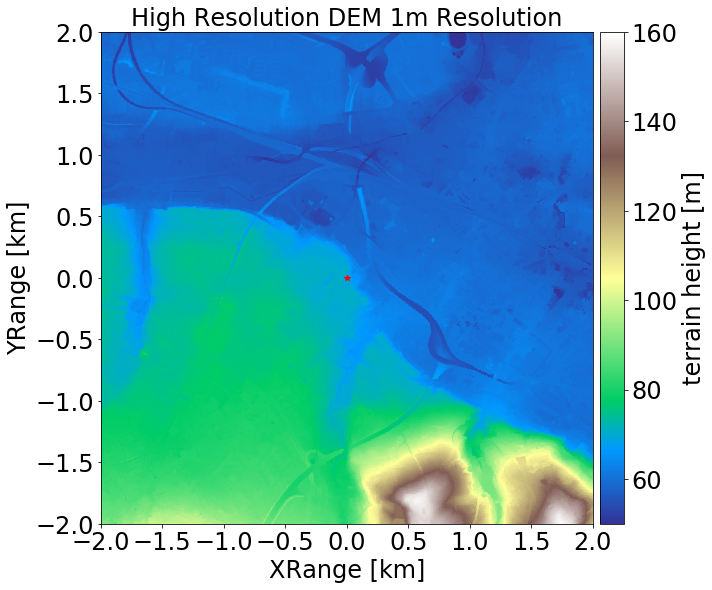

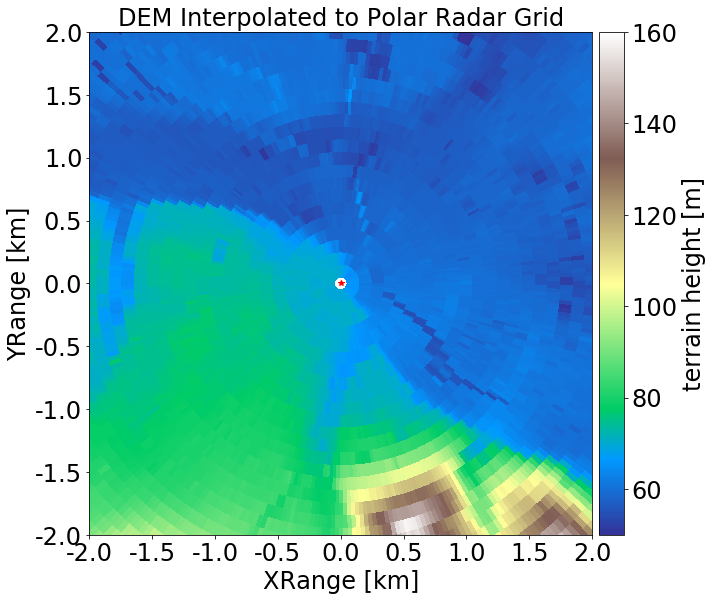

In [147]:
plot_1()
plot_2()

### Comparison Highres DEM with interpolated DEM in polar coordinates 

Interpolated DEM | Hi-resolution DEM
- | - 
![DEM interpolated to polar Grid](assets/image_002.png) | ![Hi-resolution DEM](assets/image_001.png)

![Interpolated DEM](assets/image_002.png)

### Comparison 3D representation of interpolated DEM values with original resolution

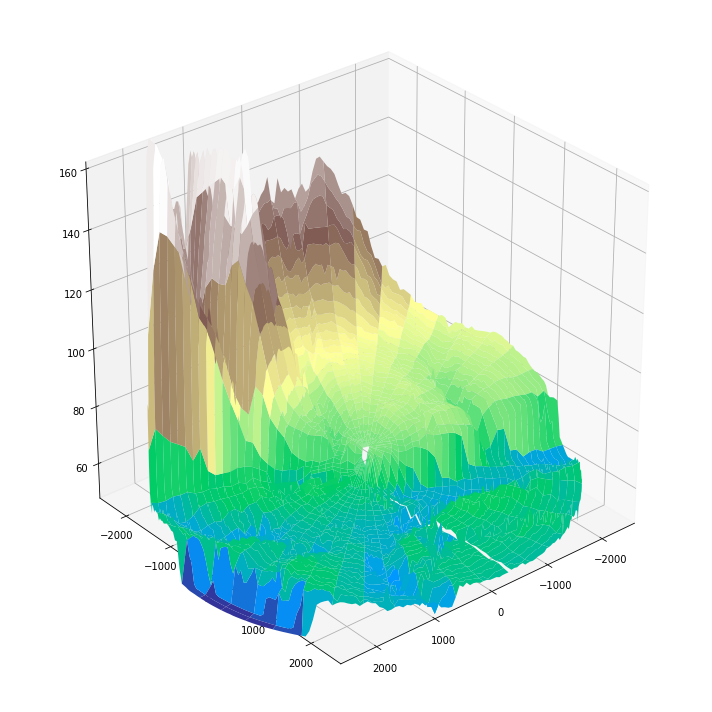

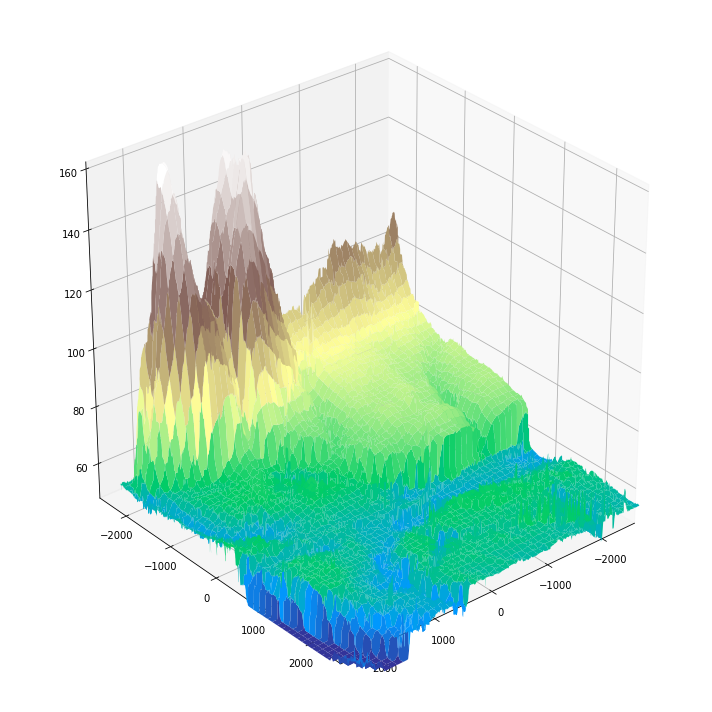

In [270]:
from mpl_toolkits.mplot3d import Axes3D
fig = pl.figure(figsize=(10,10))
ax1 = fig.add_subplot(111, projection='3d')
ax1.plot_surface(polcoords[:, 0:30, 0], polcoords[:, 0:30, 1],
                 polarvalues[:, 0:30], cmap=pl.cm.terrain,
                 norm=LogNorm(),
                 vmin=50, 
                 vmax=160)
ax1.view_init(30, 50)
ax1.set_zlim3d(50,160)
ax1.set_xlim3d(-2500,2500)
ax1.set_ylim3d(-2500,2500)
pl.tight_layout()
pl.savefig("assets/image_003.png")

fig = pl.figure(figsize=(10,10))
ax2 = fig.add_subplot(111, projection='3d')
st = 2500
sp = 7500
ax2.plot_surface(dem_xyz[st:sp, st:sp, 0], 
                 dem_xyz[st:sp, st:sp, 1], 
                 dem_xyz[st:sp, st:sp, 2],
                 cmap=pl.cm.terrain,
                 norm=LogNorm(),
                 vmin=50, 
                 vmax=160)
ax2.view_init(30, 50)
ax2.set_zlim3d(50,160)
ax2.set_xlim3d(-2500,2500)
ax2.set_ylim3d(-2500,2500)
pl.tight_layout()
pl.savefig("assets/image_004.png")

Interpolated DEM | Hi-Res DEM
- | - 
![DEM interpolated to polar Grid](assets/image_003.png) | ![Hi-res DEM](assets/image_004.png)

## New Approach

* interpolating DEM values to bin centroids ignores variation in terrain height within the sampling volume AND the nonuniform energy distribution in the sampling volume.

* explicit consideration of terrain hight variations using hi-res DEM only makes sense, if we take beam energy distribution into account.

* an elegant approach is to <span style="color:red">bring DEM coordinates and radar bin coordinates in one coherent spherical coordinate system </span>

* possible using standard wradlib georeferencing functions 

## Workflow



 


* Create radar coordinates in spherical coordinate system
* Reproject DEM to the same spherical coordinate system

* Digitize DEM coordinates over azimuth and range 
* Calculate azimuth and elevation arrays for every radar range

* Create high resolution azimuth arrays of elevation 
* Create azimuthal projection of elevation along range

* Iterate over azimuth's and match Gaussian Beam Kernel with Elevation to calculate blocked energy ratio

In [ ]:
## Workflow

* create radar coordinates in spherical coordinate system
* load DEM and reproject to the same spherical coordinate system
    * refraction dependent, takes $k_e$ as keyword argument, defaulting to standard athmosphere ($k_e$=4./3.).
* digitize over azimuth and range 
    * 360 degrees with arbitrary resolution (0.1 degree)
    * radar range with resolution of radar bin (100m) 
* Calculate azimuth and theta arrays for every range
* Create High Res Azimuth Data
    * interpolation to common grid
    * maximum accumulate along range
* Match Gaussian Beam Kernel  with Terrain
    * For one particular range, azimuth and elevation.


In [149]:
%%time
from wradlib.georef import xyz_to_spherical
r1, phi1, theta1 = xyz_to_spherical(dem_xyz, sitecoords[2], proj=rad, ke=4./3.)

CPU times: user 10.9 s, sys: 2 s, total: 12.9 s
Wall time: 12.9 s


In [150]:
%%time
# digitization over azimuth
ph = np.digitize(phi1, np.arange(0, 360, 0.1))
# digitization over range
rh = np.digitize(r1, np.arange(0, 100000., 100.))
th = theta1.copy()
print(ph.shape, ph.min(), ph.max())
print(rh.shape, rh.min(), rh.max())

(10000, 10000) 1 3600
(10000, 10000) 1 74
CPU times: user 2.98 s, sys: 208 ms, total: 3.19 s
Wall time: 3.19 s


In [151]:
azi_idx = (ph > 0) & (ph < 3600)

az_arr = []
th_arr = []
rh_arr = []

from tqdm import tnrange, tqdm_notebook
for r in tqdm_notebook(np.arange(rh.min(), rh.max())):
    
    r_idx = (rh >= r) & (rh < r + 1)
    idx = azi_idx & r_idx
    az = phi1[idx]
    az_idx = np.argsort(az)
    az_arr.append(az[az_idx])
    th_arr.append(th[idx][az_idx])
    rh_arr.append(r1[idx][az_idx])
    
az_arr = np.array(az_arr)    
th_arr = np.array(th_arr)
rh_arr = np.array(rh_arr)

### Diagnostic Plot for 3 ranges

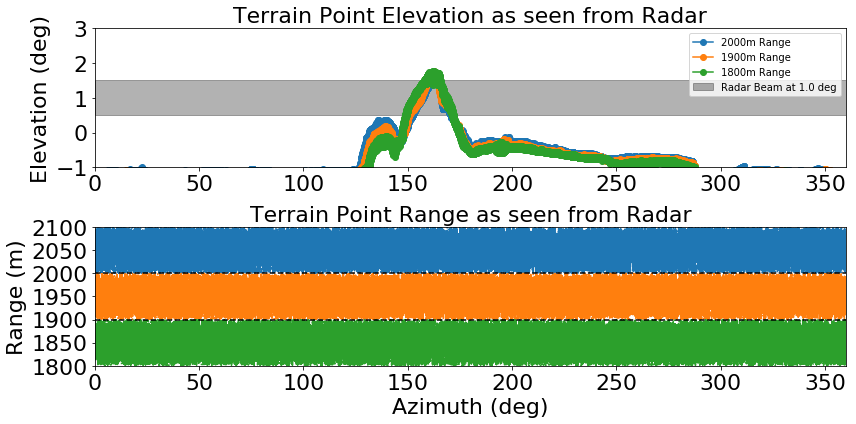

In [166]:
el = 1.0
i = 19
start_azi = 0
stop_azi = 360
fig = pl.figure(figsize=(12,6))
#fig.suptitle('Azimuth {0}deg-{1}deg'.format(start_azi, stop_azi), y=1.05)
ax1 = fig.add_subplot(211)
sp = 60
ax1.plot(az_arr[i+1][::sp], th_arr[i+1][::sp], '-o', label='{}m Range'.format((i+1)*100))
ax1.plot(az_arr[i][::sp], th_arr[i][::sp], '-o', label='{}m Range'.format((i)*100))
ax1.plot(az_arr[i-1][::sp], th_arr[i-1][::sp], '-o', label='{}m Range'.format((i-1)*100))
ax1.axhspan(el - bw / 2., el + bw / 2., color='k', alpha=0.3, 
            label='Radar Beam at {} deg'.format(el))
ax1.set_xlim(start_azi, stop_azi)
ax1.set_ylim(-1, 3)

ax1.set_ylabel('Elevation (deg)', size=22)
#ax1.set_title('Azimuth {}deg-{}deg'.format(start_azi, stop_azi))
ax1.legend()
ax1.set_title('Terrain Point Elevation as seen from Radar', size=24)
for item in ([ax1.title, ax1.xaxis.label, ax1.yaxis.label] +
                 ax1.get_xticklabels() + ax1.get_yticklabels()):
    item.set_fontsize(22)

ax2 = fig.add_subplot(212)
ax2.plot(az_arr[i+1][::sp], rh_arr[i+1][::sp], '-.', label='{}m Range'.format((i+1)*100))
ax2.plot(az_arr[i][::sp], rh_arr[i][::sp], '-.', label='{}m Range'.format((i)*100))
ax2.plot(az_arr[i-1][::sp], rh_arr[i-1][::sp], '-.', label='{}m Range'.format((i-1)*100))
for d in np.arange((i)*100, (i+2)*100, 100):
    ax2.axhline(d, c='k', ls='dashed', label='radar bin borders')
ax2.set_xlim(start_azi, stop_azi)
ax2.set_ylim((i-1) * 100, (i+2) * 100)
#ax2.set_ylim((i-1), (i+5))
#ax2.legend()
ax2.set_xlabel('Azimuth (deg)', size=22)
ax2.set_ylabel('Range (m)', size=22)
ax2.set_title('Terrain Point Range as seen from Radar', size=24)
for item in ([ax2.title, ax2.xaxis.label, ax2.yaxis.label] +
                 ax2.get_xticklabels() + ax2.get_yticklabels()):
    item.set_fontsize(22)
pl.tight_layout()
pl.savefig("assets/image_005.png")

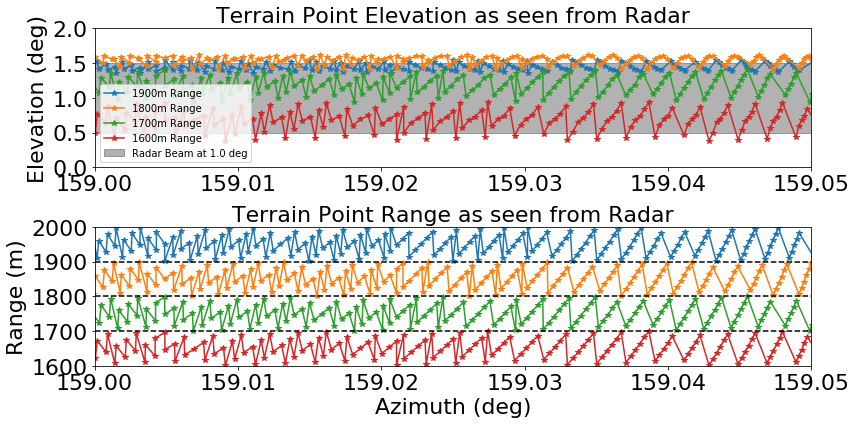

In [161]:
el = 1.0
i = 17
start_azi = 159.0
stop_azi = 159.05
fig = pl.figure(figsize=(12,6))
#fig.suptitle('Azimuth {0}deg-{1}deg'.format(start_azi, stop_azi), size=24, 
#             y=1.05)
ax1 = fig.add_subplot(211)
sp = 1
ax1.plot(az_arr[i+2][::sp], th_arr[i+2][::sp], '-*', label='{}m Range'.format((i+2)*100))
ax1.plot(az_arr[i+1][::sp], th_arr[i+1][::sp], '-*', label='{}m Range'.format((i+1)*100))
ax1.plot(az_arr[i][::sp], th_arr[i][::sp], '-*', label='{}m Range'.format((i)*100))
ax1.plot(az_arr[i-1][::sp], th_arr[i-1][::sp], '-*', label='{}m Range'.format((i-1)*100))
ax1.axhspan(el - bw / 2., el + bw / 2., color='k', alpha=0.3, 
            label='Radar Beam at {} deg'.format(el))
ax1.set_xlim(start_azi, stop_azi)
ax1.set_ylim(0, 2)
ax1.set_ylabel('Elevation (deg)', size=22)
ax1.set_title('Azimuth {}deg-{}deg'.format(start_azi, stop_azi))
ax1.legend()
ax1.set_title('Terrain Point Elevation as seen from Radar',
              size=24)
for item in ([ax1.title, ax1.xaxis.label, ax1.yaxis.label] +
                 ax1.get_xticklabels() + ax1.get_yticklabels()):
        item.set_fontsize(22)

ax2 = fig.add_subplot(212)
ax2.plot(az_arr[i+2][::sp], rh_arr[i+2][::sp], '-*', label='{}m Range'.format((i+2)*100))
ax2.plot(az_arr[i+1][::sp], rh_arr[i+1][::sp], '-*', label='{}m Range'.format((i+1)*100))
ax2.plot(az_arr[i][::sp], rh_arr[i][::sp], '-*', label='{}m Range'.format((i)*100))
ax2.plot(az_arr[i-1][::sp], rh_arr[i-1][::sp], '-*', label='{}m Range'.format((i-1)*100))
for k, d in enumerate(np.arange((i)*100, (i+3)*100, 100)):
    if k:
        ax2.axhline(d, c='k', ls='dashed', label='radar bin borders')
    else:
        ax2.axhline(d, c='k', ls='dashed')
ax2.set_xlim(start_azi, stop_azi)
ax2.set_ylim((i-1) * 100, (i+3) * 100)
ax2.set_ylabel('Range (m)', size=22)
#ax2.set_ylim((i-1), (i+5))
#ax2.legend()
ax2.set_xlabel('Azimuth (deg)', size=22)
ax2.set_title('Terrain Point Range as seen from Radar',
              size=24)
for item in ([ax2.title, ax2.xaxis.label, ax2.yaxis.label] +
                 ax2.get_xticklabels() + ax2.get_yticklabels()):
        item.set_fontsize(22)
pl.tight_layout()
pl.savefig("assets/image_006.png")

### Diagnostic Plot for 3 ranges

![Azimuthal Distribution of Elevation and Range](assets/image_005.png)

### Diagnostic Plot for 4 ranges

![Azimuthal Distribution of Elevation and Range](assets/image_006.png)

### What do we have so far?

* High Resolution DEM in Spherical Coordinates (as seen from radar)

* digitized in range 

### Create High Res Azimuth Data

* interpolation to common grid
* maximum accumulate along range

In [168]:
azi_hr = np.arange(0, 360, 0.01)
print(azi_hr.shape)
#print(az2.shape)
th_hr = []
for i in np.arange(len(az_arr)):
    x = az_arr[i]
    y = th_arr[i]
    th_hr.append(np.interp(azi_hr, x, y))
th_hr = np.array(th_hr).T
print(th_hr.shape)
th_hr[:, 0] = -10
th_maxacc = np.maximum.accumulate(th_hr, axis=1)
print(th_maxacc.shape)

(36000,)
(36000, 73)
(36000, 73)


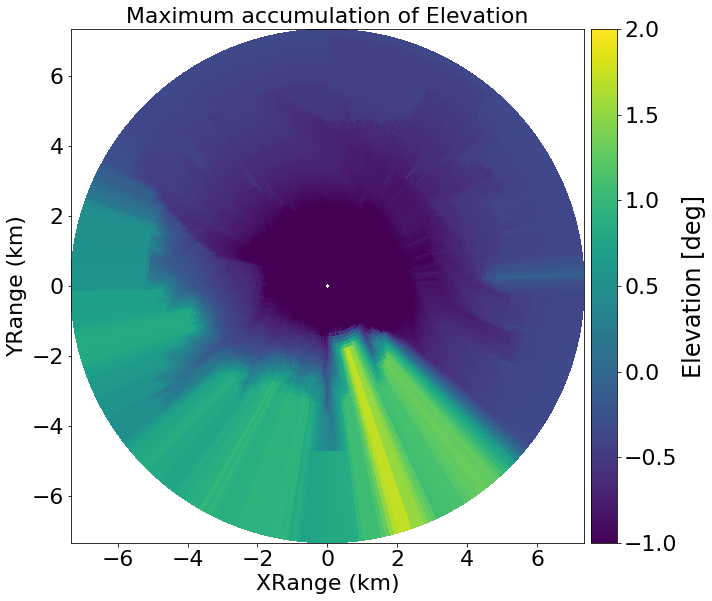

In [206]:
#print(polarvalues.shape, gr_xyz.shape)
small1_xyz = gr_xyz.copy()
small1_xyz[..., 2] = polarvalues

fig = pl.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.set_title('Maximum accumulation of Elevation')
# calculate spherical coordinates
r2, phi2, th2 = wrl.georef.xyz_to_spherical(small1_xyz, sitecoords[2], proj=rad)

ax, pm = wrl.vis.plot_ppi(th_maxacc[::100], 
                          r=r2[0,0:73]/1000., 
                          az=azi_hr[::100], 
                          vmin=-1, vmax=2., ax=ax)
div1 = make_axes_locatable(ax)
cax1 = div1.append_axes("right", size="5%", pad=0.1)
cb = pl.gcf().colorbar(pm, cax=cax1)
cb.set_label('Elevation [deg]', size=24)
ax.set_xlabel('XRange (km)')
ax.set_ylabel('YRange (km)')
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(22)
cb.ax.tick_params(labelsize=22)
pl.tight_layout()
pl.savefig("assets/image_007.png")

![Maximum Accumulation of Elevations along Range](assets/image_007.png)

In [173]:
# https://github.com/tiagopereira/python_tips/blob/master/code/trapz2d.py
def trapz2d(z,x=None,y=None,dx=1.,dy=1.):
    ''' Integrates a regularly spaced 2D grid using the composite trapezium rule. 
    IN:
       z : 2D array
       x : (optional) grid values for x (1D array)
       y : (optional) grid values for y (1D array)
       dx: if x is not supplied, set it to the x grid interval
       dy: if y is not supplied, set it to the x grid interval
    '''
    import numpy as N
    
    sum = N.sum
    if x != None:
        dx = (x[-1]-x[0])/(N.shape(x)[0]-1)
    if y != None:
        dy = (y[-1]-y[0])/(N.shape(y)[0]-1)    
    
    s1 = z[0,0] + z[-1,0] + z[0,-1] + z[-1,-1]
    s2 = sum(z[1:-1,0]) + sum(z[1:-1,-1]) + sum(z[0,1:-1]) + sum(z[-1,1:-1])
    s3 = sum(z[1:-1,1:-1])
    
    return 0.25*dx*dy*(s1 + 2*s2 + 4*s3)

In [174]:
import scipy.ndimage.filters as fi

def gkern2(kernlen=21, nsig=3):
    """Returns a 2D Gaussian kernel array."""

    # create nxn zeros
    inp = np.zeros((kernlen, kernlen))
    # set element at the middle to one, a dirac delta
    inp[kernlen//2, kernlen//2] = 1
    # gaussian-smooth the dirac, resulting in a gaussian filter mask
    return fi.gaussian_filter(inp, nsig)

def fwhm2sigma(fwhm):
    return fwhm / np.sqrt(8 * np.log(2))

### Match Gaussian Beam Kernel  with Terrain

* For one particular range, azimuth and elevation.

In [175]:
gauss = gkern2(201, nsig=fwhm2sigma(101))
gauss1 = gauss.copy()

Full Gauss: 0.9976106663274953


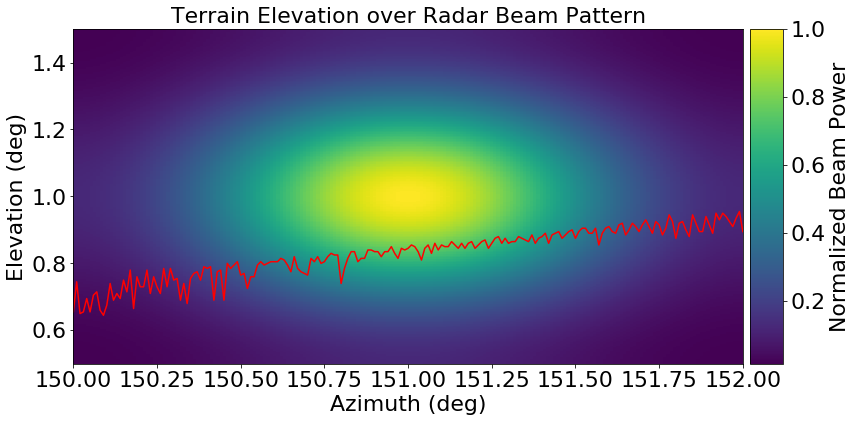

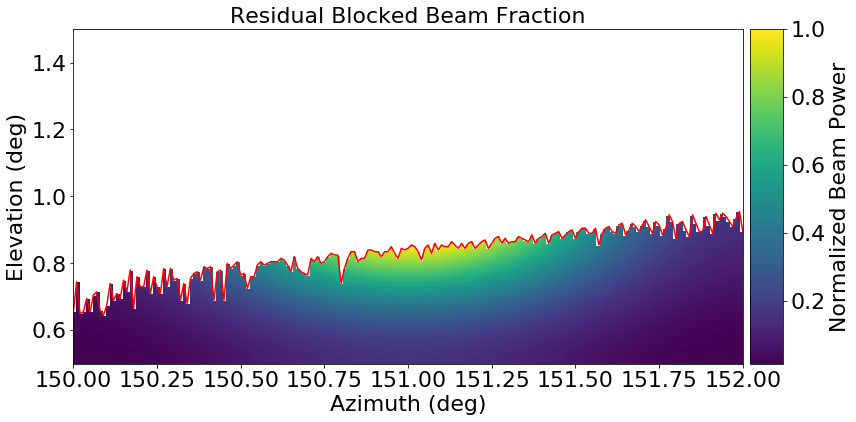

In [208]:
el = 1.0
ele_start = el - bw/2
ele_stop = el + bw/2
azangle = 151
azi_start = azangle - 1
azi_stop = azangle + 1
rng_idx = 18
az_idx = azangle * 100
full = trapz2d(gauss)
print("Full Gauss:", full)
gauss_x = np.linspace(azi_start, azi_stop, 201)
gauss_y = np.linspace(ele_start, ele_stop, 201)
th_beam = th_maxacc[az_idx - 100:az_idx + 101, rng_idx]
ss = np.searchsorted(gauss_y, th_beam)
#print("SS:", ss.shape)
for i, sidx in enumerate(ss):
    gauss1[sidx:, i] = 0
#pl.figure(figsize=(12, 8))
#pl.imshow(gauss1)
blocked = trapz2d(gauss1)
#print(ss)
#print("Blocked Gauss:", blocked)
#print("BBF:", blocked/full)
fig = pl.figure(figsize=(12, 8))
ax = fig.add_subplot(111, aspect='equal')
pm = ax.imshow(gauss/gauss.max(), interpolation='none', origin='lower', 
               extent=[azi_start, azi_stop, ele_start, ele_stop])
ax.plot(np.linspace(azi_start, azi_stop, 201), gauss_y[ss], 'r' )
ax.set_xlabel('Azimuth (deg)', size=22)
ax.set_ylabel('Elevation (deg)', size=22)
ax.set_title('Terrain Elevation over Radar Beam Pattern', size=22)
div1 = make_axes_locatable(ax)
cax1 = div1.append_axes("right", size="5%", pad=0.1)
cb = pl.gcf().colorbar(pm, cax=cax1)
cb.set_label('Normalized Beam Power', size=22)
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(22)
cb.ax.tick_params(labelsize=22)
fig.tight_layout()
fig.savefig("assets/image_008.png")

fig = pl.figure(figsize=(12, 8))
ax = fig.add_subplot(111, aspect='equal')
ax.imshow(np.ma.masked_equal(gauss1, 0), interpolation='none', origin='lower', 
          extent=[azi_start, azi_stop, ele_start, ele_stop])
ax.plot(np.linspace(azi_start, azi_stop, 201), gauss_y[ss], 'r' )
ax.set_xlabel('Azimuth (deg)', size=22)
ax.set_ylabel('Elevation (deg)', size=22)
ax.set_title('Residual Blocked Beam Fraction', size=22)
div1 = make_axes_locatable(ax)
cax1 = div1.append_axes("right", size="5%", pad=0.1)
cb = pl.gcf().colorbar(pm, cax=cax1)
cb.set_label('Normalized Beam Power', size=22)
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(22)
cb.ax.tick_params(labelsize=22)
fig.tight_layout()
fig.savefig("assets/image_009.png")

## Terrain height over gaussian beam pattern
![Terrain Height over Gauss Beam Pattern](assets/image_008.png)

## Blocked beam fraction
![Blocked Beam Fraction](assets/image_009.png)

### Processing Full Domain

* create azimuthal projection of terrain data (elevations)


In [188]:
ss = np.searchsorted(gauss_y, th_maxacc)
print(ss.shape, th_maxacc.shape)
#print(ss[15400:15600, 14])

(36000, 73) (36000, 73)


* iterate over azimuth angles and calculate blocked energy ratio

In [189]:
bbf = np.zeros((360, 73))
mask = np.zeros((201,201), dtype=np.bool)
from tqdm import tqdm_notebook as progress
for az_angle in progress(np.arange(1, 360)):
    #print(az_angle)
    azangle = az_angle * 100
    azi_start = azangle - 100
    azi_stop = azangle + 101
    #print(azi_start, azi_stop)
    #tmask = mask[:, azi_start:azi_stop, :]
    #print(tmask.shape)
    for r_step in range(bbf.shape[-1]):
        msk = mask.copy()
        for six, sval in enumerate(ss[azi_start: azi_stop, r_step]):
            msk[sval:, six] = True
        #print(msk.shape)
        bbf[az_angle, r_step] = trapz2d(np.ma.masked_array(gauss, mask=msk).filled(0))

* normalize results with full beam pattern energy

In [190]:
bbf_norm = bbf/full

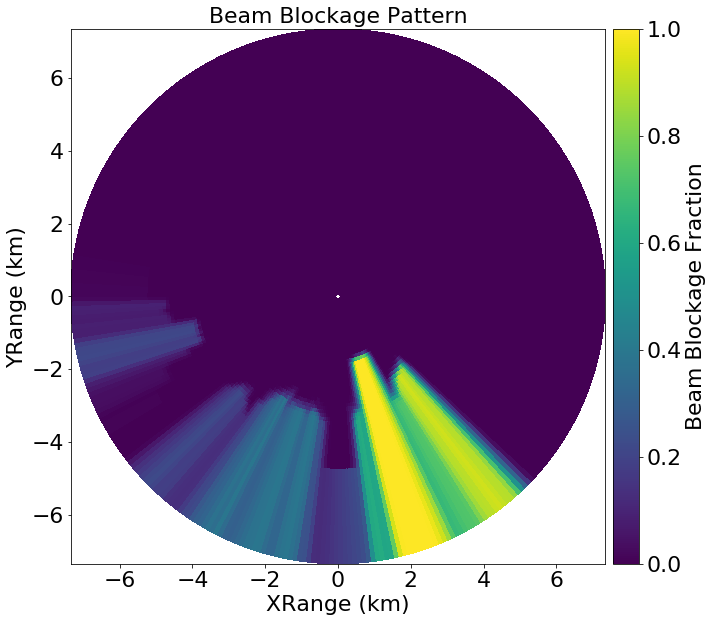

In [204]:
fig = pl.figure(figsize=(10, 10))
ax1 = fig.add_subplot(111)

ax1, pm = wrl.vis.plot_ppi(bbf_norm, 
                            r=r2[0,0:73]/1000., 
                            az=azi_hr[::100],
                            #cmap=mpl.cm.PuRd, #norm=LogNorm(), 
                            ax=ax1, vmax=1.0)
ax1.set_xlabel('XRange (km)', size=22)
ax1.set_ylabel('YRange (km)', size=22)
#ax1.set_xlim(-2, 2)
#ax1.set_ylim(-2, 2)
ax1.set_title('Beam Blockage Pattern', size=22)
div1 = make_axes_locatable(ax1)
cax1 = div1.append_axes("right", size="5%", pad=0.1)
cb = pl.gcf().colorbar(pm, cax=cax1)
cb.set_label('Beam Blockage Fraction', size=22)
for item in ([ax1.title, ax1.xaxis.label, ax1.yaxis.label] +
                 ax1.get_xticklabels() + ax1.get_yticklabels()):
    item.set_fontsize(22)
cb.ax.tick_params(labelsize=22)
fig.tight_layout()
fig.savefig('assets/image_010.png')

![Beam Blockage Pattern](assets/image_010.png)

## Acknowledgments

* Alper Çubuk and Kurtuluş Öztürk from Turkish Met Service

* High Resolution DGM1 Data (1mx1m): Land NRW (2018) 
[Datenlizenz  Deutschland - Namensnennung - Version 2.0](www.govdata.de/dl-de/by-2-0)

| ![python](https://upload.wikimedia.org/wikipedia/commons/f/f8/Python_logo_and_wordmark.svg) | ![wradlib](https://wradlib.org/extra/wradlib_logo.svg.png) | ![GDAL](https://upload.wikimedia.org/wikipedia/commons/d/df/GDALLogoColor.svg) | <img src="https://upload.wikimedia.org/wikipedia/en/1/1b/NumPy_logo.png" alt="numpy" width="400px"/> |
| --- | --- | --- | --- |
| | | | |


<h1><center>QUESTIONS?</center></h1>

| ![SciPy](https://www.fullstackpython.com/img/logos/scipy.png) | ![Matplotlib](https://matplotlib.org/_static/logo2.png) | <img src="http://jupyter.org/assets/main-logo.svg" alt="jupyter" width="400px"/> | ![Github](https://assets-cdn.github.com/images/modules/logos_page/GitHub-Mark.png) |
| --- | --- | --- | --- |
| | | | |
